In [24]:
import pandas as pd
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp 

In [2]:
QUALFILE = "ED_Main_Spring_2023_March+31,+2023_13.40.csv"
df_qual = pd.read_csv("..\data\{}".format(QUALFILE))

KEYFILE = "key.csv"
df_key = pd.read_csv("..\data\{}".format(KEYFILE))

In [3]:
df_qual

,RecordedDate,ID,session,Q1_1,Q1_2
0,Recorded Date,Thank you for participating in our study. Plea...,Enter test-session,Do you think the drink you just had contains c...,Do you think the drink you just had contains c...
1,"{""ImportId"":""recordedDate"",""timeZone"":""Europe/...","{""ImportId"":""QID21_TEXT""}","{""ImportId"":""QID14""}","{""ImportId"":""QID1211366423_1""}","{""ImportId"":""QID1211366423_2""}"
2,2023-02-15 11:58:54,NaN,1st test,6,4
3,2023-03-06 15:37:12,1111,1st test,8,8
4,2023-03-06 15:39:52,1111,1st test,8,8
...,...,...,...,...,...
214,2023-03-29 15:27:32,3054,3rd test,3,10
215,2023-03-29 15:28:03,3048,3rd test,4,6
216,2023-03-29 15:33:58,9085,3rd test,7,9
217,2023-03-29 15:35:04,9245,3rd test,2,3


In [4]:
df_key

,ID,T1,T2,T3
0,2009,DCXS,CS,CXS
1,2054,DCXS,CS,CXS
2,3024,DCXS,CS,CXS
3,4010,DCXS,CS,CXS
4,5052,DCXS,CS,CXS
...,...,...,...,...
67,6080,DCXS,DCXS,CS
68,7084,DCXS,DCXS,CS
69,7096,DCXS,DCXS,CS
70,7108,DCXS,DCXS,CS


In [5]:
# Attention! If we look at T1 as well we will have to make some adjustments to ID numbers - see osf wiki

In [6]:
def tweak_key(df):
    return(df
           .drop(df.index[df.ID == 2018])
           .assign(ID=lambda df_: df_.ID.astype(str))
           .melt(id_vars="ID")
           .rename(columns={"variable": "session",
                            "value": "condition"})
           .assign(session=lambda df_: df_.session.astype("category"),
                   condition=lambda df_: df_.condition.astype("category"))
          )

def tweak_qual(df, df_key):
    IDs = df_key.ID.unique()
    
    return(df
           .rename(columns={"Q1_1": "caffeine", "Q1_2": "sugar"})
           .replace({"1st test": "T1", "2nd test": "T2", "3rd test": "T3"})
           .query("ID in @IDs")
           .assign(session=lambda df_: df_.session.astype("category"),
                   caffeine=lambda df_: df_.caffeine.astype("uint8"),
                   sugar=lambda df_: df_.sugar.astype("uint8"))
           .merge(df_key)
          )


KEYFILE = "key.csv"
df_key = pd.read_csv("..\data\{}".format(KEYFILE))
df_key = tweak_key(df_key)

QUALFILE = "ED_Main_Spring_2023_March+31,+2023_13.40.csv"
df_qual = pd.read_csv("..\data\{}".format(QUALFILE))
df_qual = tweak_qual(df_qual, df_key)

df_qual.tail(5)

,RecordedDate,ID,session,caffeine,sugar,condition
192,2023-03-29 15:27:32,3054,T3,3,10,CS
193,2023-03-29 15:28:03,3048,T3,4,6,DCS
194,2023-03-29 15:33:58,9085,T3,7,9,DCS
195,2023-03-29 15:35:04,9245,T3,2,3,CS
196,2023-03-30 13:58:08,3060,T3,7,0,CS


In [7]:
len(df_qual)

197

In [8]:
print("The number of T1 rows is {}.".format(sum(df_qual.session == "T1")))
print("The number of T2 rows is {}.".format(sum(df_qual.session == "T2")))
print("The number of T3 rows is {}.".format(sum(df_qual.session == "T3")))

The number of T1 rows is 71.
The number of T2 rows is 65.
The number of T3 rows is 61.


In [9]:
df_qual.groupby(by="ID").count()

,RecordedDate,session,caffeine,sugar,condition
ID,,,,,
2009,3,3,3,3,3
2036,3,3,3,3,3
2054,3,3,3,3,3
2063,3,3,3,3,3
2072,3,3,3,3,3
...,...,...,...,...,...
9102,2,2,2,2,2
9136,3,3,3,3,3
9170,2,2,2,2,2


In [10]:
# function to get difference scores
def get_diff_scores(df, conditions, value):
    
    sessions = ["T2", "T3"]
    df_reduced = (df
                  .query("condition in @conditions")
                  .query("session in @sessions")
                 )
    
    df_diff = pd.pivot(df_reduced, index="ID", columns="condition", values=value)
    df_diff["difference_score"] = df_diff[conditions[0]] - df_diff[conditions[1]]
        
    df_diff = df_diff[~pd.isna(df_diff["difference_score"])]
    
    return df_diff

# df_qual = df_qual.query()

conditions = ["CS", "DCS"]
df_caffeine = get_diff_scores(df_qual, conditions, "caffeine")
df_caffeine_sug = get_diff_scores(df_qual, conditions, "sugar")

conditions = ["CS", "CXS"]
df_sugar = get_diff_scores(df_qual, conditions, "sugar")
df_sugar_caff = get_diff_scores(df_qual, conditions, "caffeine")

conditions = ["CS", "DCXS"]
df_both_caff = get_diff_scores(df_qual, conditions, "caffeine")
df_both_sug = get_diff_scores(df_qual, conditions, "sugar")


In [11]:
print("The number of subjects with CS vs DCS is {}".format(len(df_caffeine)))
print("The number of subjects with CS vs CXS is {}".format(len(df_sugar)))
print("The number of subjects with CS vs DCXS is {}".format(len(df_both_caff)))

The number of subjects with CS vs DCS is 18
The number of subjects with CS vs CXS is 20
The number of subjects with CS vs DCXS is 23


In [12]:
df_caffeine

condition,DCS,CS,difference_score
ID,,,
2036,6.0,6.0,0.0
3012,4.0,7.0,3.0
3048,4.0,4.0,0.0
4025,4.0,3.0,-1.0
4030,7.0,7.0,0.0
4035,7.0,7.0,0.0
4050,7.0,7.0,0.0
6024,7.0,8.0,1.0
6032,6.0,5.0,-1.0


In [13]:
df_sugar.to_csv("..//results//diff_sugar.csv")

In [14]:
res = ttest_1samp(df_sugar.difference_score, 0)

if res.pvalue > 0.05:
    print("The difference scores are not different from zero, p = {:.3f}".format(res.pvalue))
else:
    print("The difference scores are different from zero, p = {:.3f}".format(res.pvalue))
    
ci = res.confidence_interval()

The difference scores are not different from zero, p = 0.132


In [15]:
df_sugar

condition,CXS,CS,difference_score
ID,,,
2009,2.0,10.0,8.0
2054,0.0,1.0,1.0
2072,4.0,9.0,5.0
2081,0.0,2.0,2.0
3024,1.0,8.0,7.0
3036,10.0,10.0,0.0
3054,8.0,10.0,2.0
4005,7.0,6.0,-1.0
4010,1.0,3.0,2.0


In [16]:
def permtest(df, iters=10000):
    """
    Permutation test for taste scores to compare difference against 0.
    Does one-tailed test so testing hypothesis that the ingredient can
    be detected not that there is a taste difference between the two
    drinks.
    
    Args
    df : DataFrame
        Contains difference_score column
    iters : Int
        Number of shuffles to perform. Default is 1000
    
    Returns
    p-value
    """
    means = []
    for i in range(iters):
        means.append(df.difference_score.apply( lambda x : x * random.choice([-1,1])).mean())
        
    real_mean = df.difference_score.mean()
    
    fraction = sum(np.array(means) > real_mean)

    return fraction / iters
    
permtest(df_sugar)


0.0595

In [17]:
print("The p-value for caffeine in CS vs DCS is {}".format(permtest(df_caffeine)))
print("The p-value for sugar in CS vs DCS is {}".format(permtest(df_caffeine_sug)))
print("The p-value for sugar in CS vs CXS is {}".format(permtest(df_sugar)))
print("The p-value for caffeine in CS vs CXS is {}".format(permtest(df_sugar_caff)))
print("The p-value for sugar in CS vs DCXS is {}".format(permtest(df_both_sug)))
print("The p-value for caffeine in CS vs DCXS is {}".format(permtest(df_both_caff)))

The p-value for caffeine in CS vs DCS is 0.7367
The p-value for sugar in CS vs DCS is 0.8028
The p-value for sugar in CS vs CXS is 0.0551
The p-value for caffeine in CS vs CXS is 0.5277
The p-value for sugar in CS vs DCXS is 0.1454
The p-value for caffeine in CS vs DCXS is 0.1358


In [18]:
df_sugar.difference_score.apply( lambda x : x * random.choice([-1,1])).mean()

-0.5

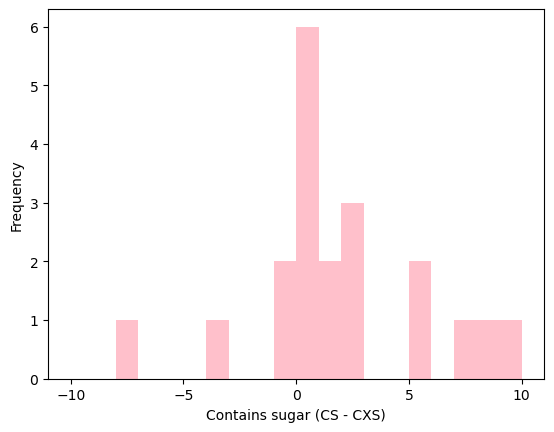

In [19]:
bins = range(-10, 11)

f, ax = plt.subplots()

ax.hist(df_sugar.difference_score, bins=bins, color="pink")
ax.set_ylabel("Frequency")
ax.set_xlabel("Contains sugar (CS - CXS)")

ax.set_xticks([-10, -5, 0, 5, 10])


Text(0.5, 0, 'Contains sugar (CS - DCXS)')

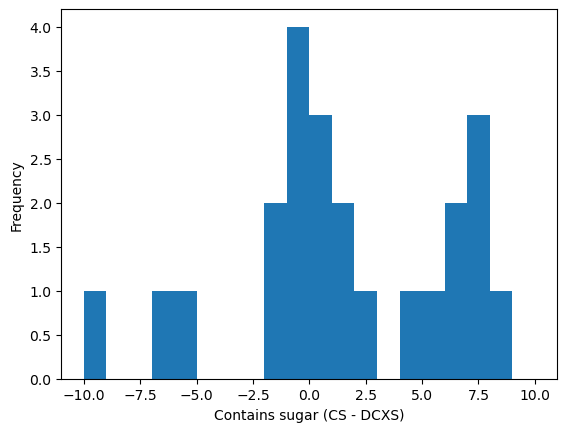

In [20]:
bins = range(-10, 11)

f, ax = plt.subplots()

ax.hist(df_both_sug.difference_score, bins=bins)
ax.set_ylabel("Frequency")
ax.set_xlabel("Contains sugar (CS - DCXS)")

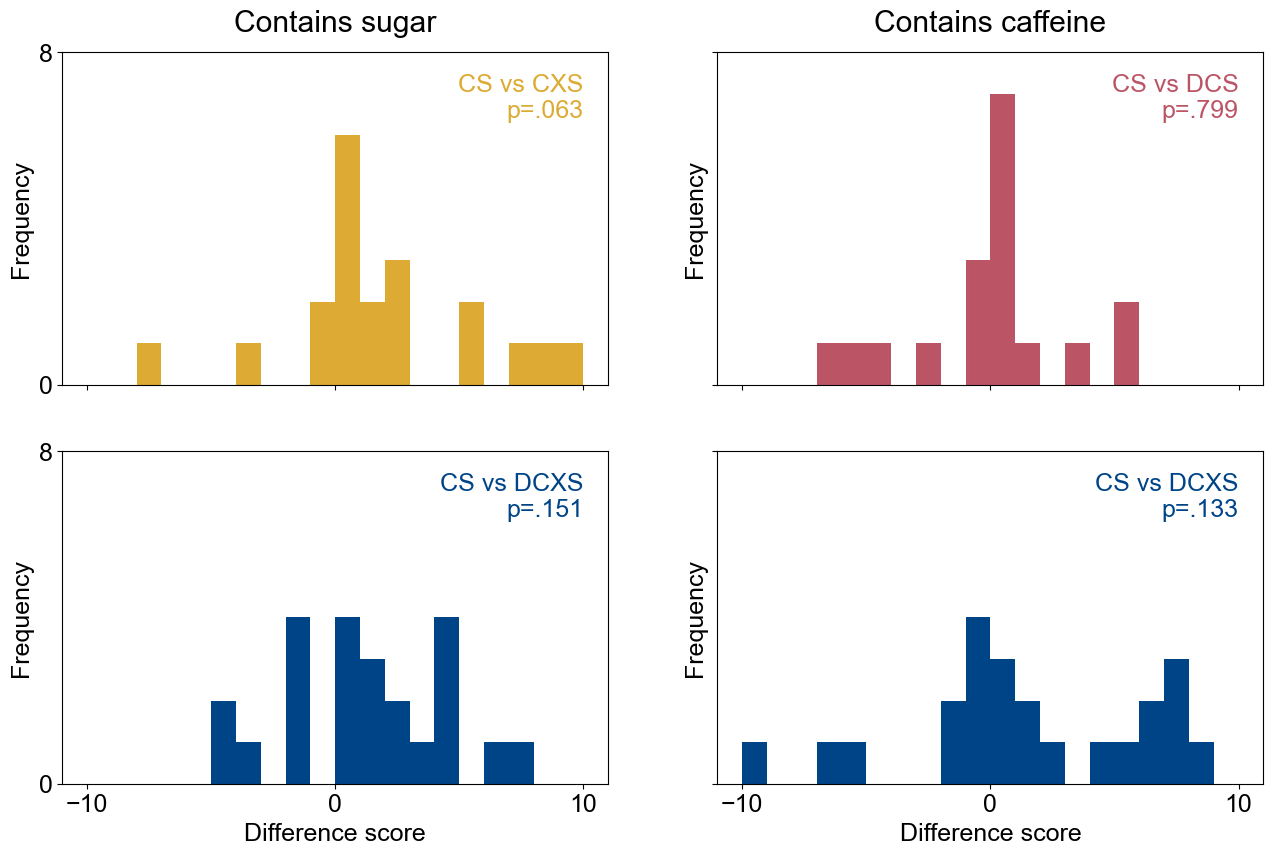

In [34]:
def make_difference_hist(df, bins, axis, color="red"):
    axis.hist(df.difference_score, bins=bins, color=color)
    axis.set_ylabel("Frequency")
    axis.set_yticks([0,8])

cs_dcs_color = "#BB5566"
cs_cxs_color = "#DDAA33"
cs_dcxs_color = "#004488"

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
    
f, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(15.5, 9.5))

make_difference_hist(df_sugar, bins, ax[0,0], color=cs_cxs_color)
make_difference_hist(df_caffeine, bins, ax[0,1], color=cs_dcs_color)

make_difference_hist(df_both_caff, bins, ax[1,0], color=cs_dcxs_color)
make_difference_hist(df_both_sug, bins, ax[1,1], color=cs_dcxs_color)

ax[1,0].set_xlabel("Difference score")
ax[1,1].set_xlabel("Difference score")

ax[0,0].text(10,7.5,"CS vs CXS\np=.063", ha="right", va="top", color=cs_cxs_color)
ax[0,1].text(10,7.5,"CS vs DCS\np=.799", ha="right", va="top", color=cs_dcs_color)
ax[1,0].text(10,7.5,"CS vs DCXS\np=.151", ha="right", va="top", color=cs_dcxs_color)
ax[1,1].text(10,7.5,"CS vs DCXS\np=.133", ha="right", va="top", color=cs_dcxs_color)

pad=15
ax[0,0].set_title("Contains sugar", pad=pad)
ax[0,1].set_title("Contains caffeine", pad=pad)


for axis in [ax[0,0], ax[1,1], ax[0,0], ax[0,0]]:
    axis.set_xticks([-10,0,10])

f.savefig("..//results//taste-scores.png")


In [195]:
rnd_array = []
for n in range(100):
    rnd_array.append(df_both_sug.difference_score.apply( lambda x : x * random.choice([-1,1])).values)


In [203]:
len(df_both_sug)

23

<Axes: ylabel='Density'>

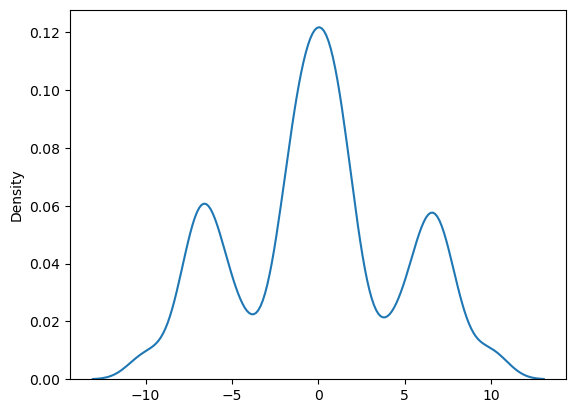

In [204]:
import seaborn as sns
import trompy as tp
rnd_array
sns.kdeplot(tp.flatten_list(rnd_array), weights=23)

In [57]:
df_caffeine.difference_score

ID
2018    6.0
2036    0.0
3012    3.0
3048    0.0
4025   -1.0
4030    0.0
4035    0.0
4050    0.0
6024    1.0
6032   -1.0
7024   -6.0
7036   -7.0
7048   -3.0
8014    0.0
8021    5.0
8042    0.0
9034    5.0
9245   -1.0
Name: difference_score, dtype: float64